# Deterministic optimisation (using the fluid model)

Here we optimise over several deterministic objective functions evaluated using the fluid flow model. 

* [This link](https://github.com/grahamburgess3/homeless_services/blob/main/notes/2024-02-19-Optim_Formulations_Specific/Optim-Formulations.pdf) gives the details of the suggested formulations.
* [This link](https://github.com/grahamburgess3/homeless_services/blob/main/08_fluid_flow_model.ipynb) details the workings of the fluid flow model.

The goal is to establish which features of a problem formulation best capture the aspects of the real-world problem we are interested in modeling. 

In [1]:
# imports
import deterministic_optimisation as do

The data below is based upon the system as it has previously been modelled by Singham et al (2023). We have increased the arrival rate to ensure that the unsheltered Q never empties

In [2]:
# Set data for system behaviour
data = {'initial_capacity' : {'housing':4000, 'shelter':1500},
        'initial_demand' : 12000, # initial number of people in system
        'service_mean' : {'housing': 4.0, 'shelter': 0.0}, # in years
        'arrival_rates' : [6000.0]*5 + [3000.0]*5,
        'budget' : 200000000, # in dollars
        'costs_accomm' : {'housing' : 30000, 'shelter' : 10000}, # cost in dollars per unit
        'baseline_build' : 500} # how many housing units and shelter units we must build at least each year

# Set modeliing options
modeling_options = {'horizon_model' : 5, # in years
                    'horizon_decision' : 5, # in years
                    'timestep' : 1/365, # in years
                    'model' : do.FluidModel}

####  $\Phi_0$ : linear penalty unsheltered Q
    # min TimeAvg(E[unsh(t)])
    # s.t. total budget constraint
    #      annual minimum build constraint

------- Optimal solution -------
Number of housing units to build annually: [500.0, 500.0, 500.0, 500.0, 500.0]
Number of shelter units to build annually: [10500.0, 500.0, 500.0, 500.0, 500.0]
Total budget: 200000000
Number of housing/shelter units which must be built annually: 500
Surplus budget: 100000000
Proportion of surplus budget spent on housing: 0%: 0.0 extra houses.
Proportion of surplus budget spent on shelter: 100%: 10000.0 extra shelters.
Optimal objective val: 6976.85


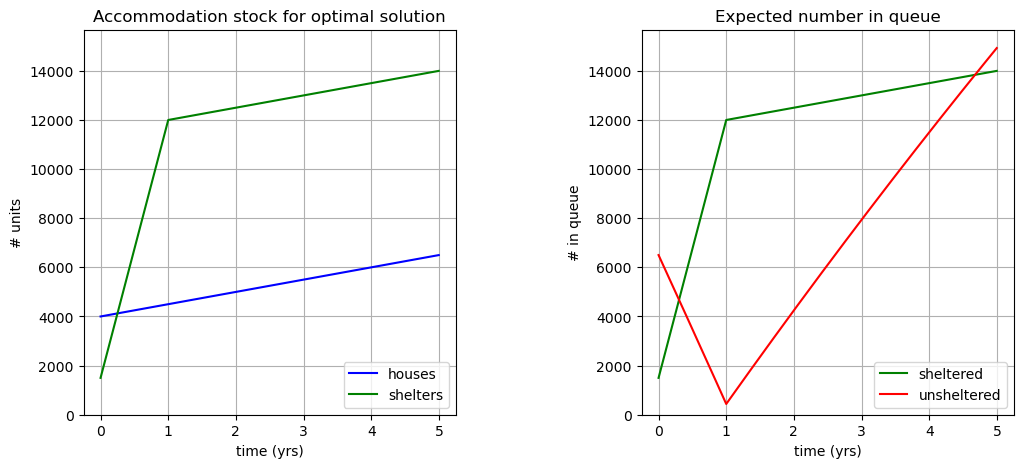

In [3]:
# Set up problem and solve
problem = do.Phi0(data, modeling_options, 'phi0')
problem.solve('glpk')

Here we see that for the given cost of shelter and given housing service rate, it is best to spend all of our surplus budget on shelter in the first year. This would immediately bring down the unsheltered queue. If we were to, say, increase the cost of shelter, our optimal solution would flip to to spend all of our surplus budget on housing in the first year. 

#### Understanding the charts
* The green lines on the left and right hand charts are equivalent: since we assume the unhseltered queue never vanishes, the size of the sheltered queue is always equal to the number of shelters, and that is related to the shelter build function in the optimal solution. 
* The blue line on the left hand side is related to the housing build function in the optimal solution.
* The red line on the right hand side (unsheltered queue) is affected by both the green and blue lines on the left. A steep green or blue line will contribute to a sharp decrease in the unsheltered queue as space is made available in housing/shelter to relieve the unsheltered queue. A large number of houses (blue line) will also lead to a greater flow out of the system and therefore contribute towards a gradual decrease in the unsheltered queue. 

####  $\Phi_1$ : linear penalty unsheltered Q and sheltered Q
    # min TimeAvg(E[unsh(t) + c*E[sh(t)]])
    # s.t. total budget constraint
    #      annual minimum build constraint

------- Optimal solution -------
Number of housing units to build annually: [3833.33, 500.0, 500.0, 500.0, 500.0]
Number of shelter units to build annually: [500.0, 500.0, 500.0, 500.0, 500.0]
Total budget: 200000000
Number of housing/shelter units which must be built annually: 500
Surplus budget: 100000000
Proportion of surplus budget spent on housing: 100%: 3333.33 extra houses.
Proportion of surplus budget spent on shelter: 0%: 0.0 extra shelters.
Optimal objective val: 12656.27


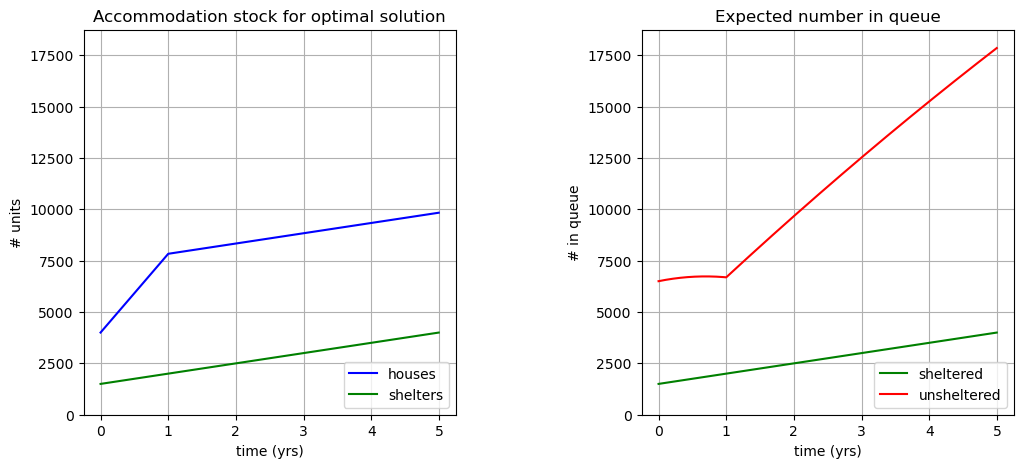

In [4]:
# Set up problem and solve
problem = do.Phi1(data, modeling_options, 'phi1', c=0.5)
problem.solve('glpk')

Here we see that by penalising the size of the sheltered queue, our preference shifts to spending all of our surplus budget on housing in the first year. 

####  $\Phi_2$ : quadratic penalty unsheltered Q and sheltered Q
    # min TimeAvg(E[unsh(t)^2] + c*E[sh(t)^2])
    # s.t. total budget constraint
    #      annual minimum build constraint

------- Optimal solution -------
Number of housing units to build annually: [3405.68, 500.0, 500.0, 500.0, 500.0]
Number of shelter units to build annually: [1782.95, 500.0, 500.0, 500.0, 500.0]
Total budget: 200000000
Number of housing/shelter units which must be built annually: 500
Surplus budget: 100000000
Proportion of surplus budget spent on housing: 87%: 2905.68 extra houses.
Proportion of surplus budget spent on shelter: 13%: 1282.95 extra shelters.
Optimal objective val: 28568211.97


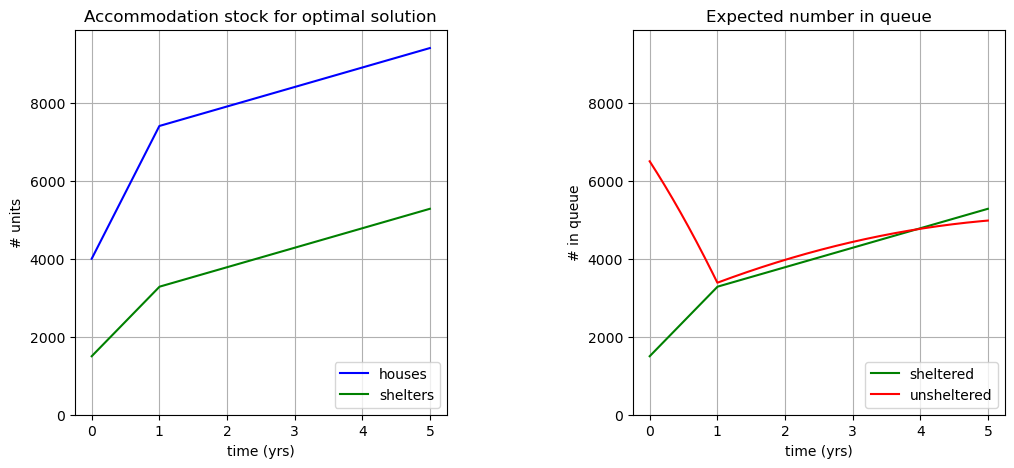

In [5]:
# change arrival rates
data['arrival_rates'] = [3500.0]*10

# Set up problem and solve
problem = do.Phi2(data, modeling_options, 'phi2', c=0.5)
problem.solve('ipopt')

With quadratic terms in the objective function, an optimal solution is encouraged to let neither the sheltered nor the unsheltered queue get too large, by building a mixture of housing and shelter. Some experimentation (not illustrated above) with different values of $c$ shows that the optimal mix is sensitive to this choice of the weight placed on the squared sheltered queue. 

####  $\Phi_3$ : Add shape constraints
    # min TimeAvg(E[unsh(t)^2] + c*E[sh(t)^2])
    # s.t. total budget constraint
    #      annual minimum build constraint
    #      shape constraint on house building: non-decreasing
    #      shape constraint on shelter building: non-decreasing and then non-increasing

------- Optimal solution -------
Number of housing units to build annually: [878.72, 878.72, 878.72, 878.72, 878.72]
Number of shelter units to build annually: [1939.71, 1939.71, 1939.71, 500.0, 500.0]
Total budget: 200000000
Number of housing/shelter units which must be built annually: 500
Surplus budget: 100000000
Proportion of surplus budget spent on housing: 57%: 1893.62 extra houses.
Proportion of surplus budget spent on shelter: 43%: 4319.13 extra shelters.
Optimal objective val: 48059322.82


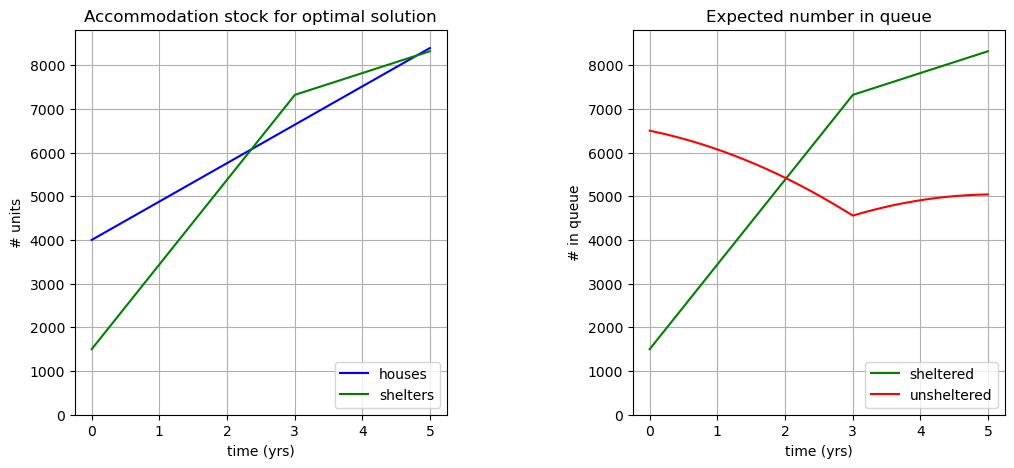

In [6]:
# Set up problem and solve
problem = do.Phi3(data, modeling_options, 'phi3', c=0.5, shelter_mode = 3)
problem.solve('ipopt')

By forcing the # new houses to either stay the same or increase from year to year, we spread the house building out equally over the year. Earlier is still always better so there is no incentive here for the # new houses to increase. Building houses later reduces their positive impact on the objective function because it takes time for the system to see their benefit of increasing the flow out of the system. Therefore, compared to $\Phi_3$ with the same $c$ value, our optimal solution has a greater preference for extra shelters, whose benefit over housing (i.e. the fact that they are cheaper) is immediate since they simply take people out of the unshelter queue and into the sheltered queue. Again, earlier is still always better so there is no incentive to build anything above the baseline after the shelter mode. 

####  $\Phi_4$ : Add time-dependency to weight on quadratic shelter penalty
    # min TimeAvg(E[unsh(t)^2]) + WeightedTimeAvg(E[sh(t)^2])
    # s.t. total budget constraint
    #      annual minimum build constraint
    #      shape constraint on house building: increasing
    #      shape constraint on shelter building: increasing and then decreasing

Here we work with a weight function $w(t)$ which is linear and non-decreasing w.r.t time. We require the $w(t)$ function to reach a maximum of $\frac{1}{horizon}$ since this is the constant weight by which we penalise the squared unsheltered queue. Therefore the gradient of $w(t)$ has a lower bound of $0$ and upper bound of $\frac{1}{horizon^2}$. Our choice of $m$ below must take a value between $0$ and $1$ and indicates the magnitude of the gradient of $w(t)$, $0$ being no gradient, $1$ being max possible gradient. 

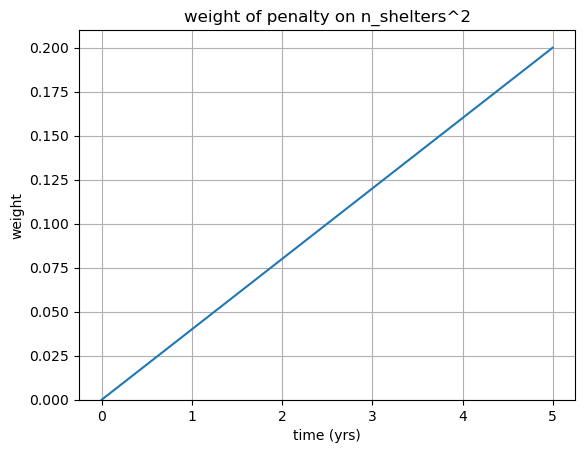

In [7]:
m = 1.0
weights = do.get_linear_weight_func(m, modeling_options['horizon_model'], modeling_options['timestep'])
do.plot_weight_func(weights, modeling_options['horizon_model'], modeling_options['timestep'])

------- Optimal solution -------
Number of housing units to build annually: [963.62, 963.62, 963.62, 963.62, 963.62]
Number of shelter units to build annually: [1515.25, 1515.25, 1515.25, 500.0, 500.0]
Total budget: 200000000
Number of housing/shelter units which must be built annually: 500
Surplus budget: 100000000
Proportion of surplus budget spent on housing: 70%: 2318.09 extra houses.
Proportion of surplus budget spent on shelter: 30%: 3045.74 extra shelters.
Optimal objective val: 53393414.21


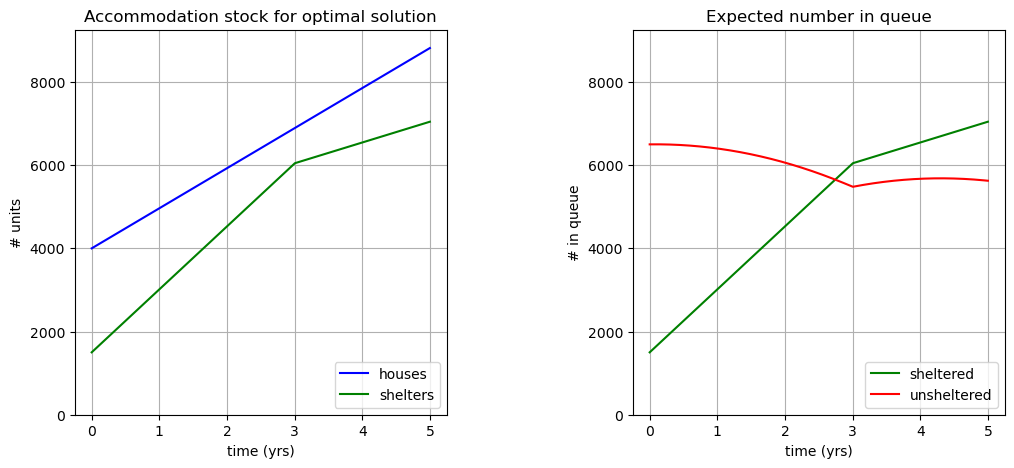

In [8]:
# Set up problem and solve
problem = do.Phi4(data, modeling_options, 'phi4', c=weights, shelter_mode = 3)
problem.solve('ipopt')

At the start of the modelled horizon, the penalty for shelter is less than the constant penalty in $\Phi_3$, but early on, the number of shelters is small. 

Towards the end of the modelled horizon, the penalty for shelter is more than the constant penalty in $\Phi_3$, and late on is where the number of shelters is at its highest. 

Therefore, compared to $\Phi_3$, there is a preference for fewer shelters, since they lead to a greater penalty when they accumulate towards the end of the horizon.

####  $\Phi_5$ : Drop shape constraints - add annual budget constraints
    # min TimeAvg(E[unsh(t)^2]) + WeightedTimeAvg(E[sh(t)^2])
    # s.t. annual increasing budget constraint

Here we introduce an annual budget constraint which increases over time, in place of a total budget constraint. We drop shape constraints and annual minimum build constraints - the quadratic objective function remains to ensure no one queue gets too large, but the weighting of the penalty on the squared shelterd queue is again time dependent. 

------- Optimal solution -------
Number of housing units to build annually: [0.0, 144.87, 1333.33, 1666.67, 2000.0]
Number of shelter units to build annually: [2000.0, 2565.4, 0.0, 0.0, 0.0]
Proportion of annual budget spent on housing: ['0%', '14%', '100%', '100%', '100%']
Proportion of annual budget spent on shelter: ['100%', '86%', '0%', '0%', '0%']
Optimal objective val: 70855990.19


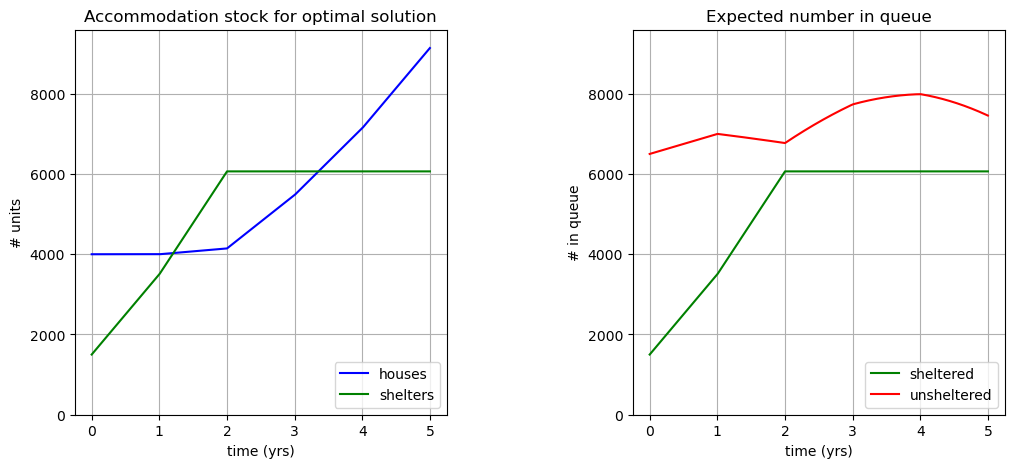

In [9]:
# Set up problem and solve
problem = do.Phi5(data, modeling_options, 'phi5', c=weights, budget_props = [0.1, 0.15, 0.2, 0.25, 0.3]) # proportions must add to 1. 
problem.solve('ipopt')

Here we see that in the early years, with a small penalty on shelter, shelter is preferred to reduce the unsheltered queue quickly as much as possible. However in later years, as the penalty on the sheltered queue approaches that of the unsheltered queue, it is prefereable to use extra housing to increase the overall throughput of the system. 

We now increase the modelled horizon to $10$ years (but keep the decision horizon to $5$ years) to see how the results are affected. This will give the benefits of the decisions taken towards the end of the decision horizon time to have a fuller effect (particularly relevant for housing). For simplicity we do not build any further housing/shelter after $5$ years, but we also reduce the arrival rate after $5$ years. 

------- Optimal solution -------
Number of housing units to build annually: [666.67, 732.58, 766.31, 1614.99, 1826.54]
Number of shelter units to build annually: [0.0, 802.26, 1701.07, 155.04, 520.39]
Proportion of annual budget spent on housing: ['100%', '73%', '57%', '97%', '91%']
Proportion of annual budget spent on shelter: ['0%', '27%', '43%', '3%', '9%']
Optimal objective val: 74542075.34


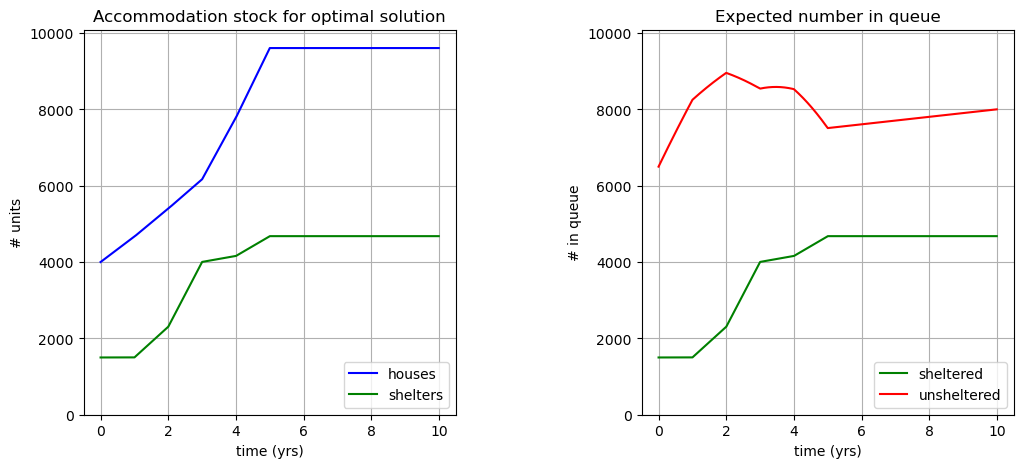

In [10]:
# change modelling horizon
modeling_options['horizon_model'] = 10 # in years
weights = do.get_linear_weight_func(m, modeling_options['horizon_model'], modeling_options['timestep'])
data['arrival_rates'] = [3500.0]*5 + [2500.0]*5

# Set up problem and solve
problem = do.Phi5(data, modeling_options, 'phi4', c=weights, budget_props = [0.1, 0.15, 0.2, 0.25, 0.3])
problem.solve('ipopt')

We now see two peaks in the proportion of the annual budget we spend on housing. This is not an intuitive solution to understand, but it is helpful to note some of the important factors at play here: 

* Housing is better built earlier rather than later so it has time to have a full effect. This benefit of early building is less strong for shelter which has an immediate effect.
* The penalty on shelter slowly increases over the modelled horizon.
* The quadratic objective function avoids solutions where either the sheltered/unsheltered queue is too high. 

#### Comments
* We could consider adding shape constraints to formulation $\Phi_5$ to avoid solutions which do not appear intuitive. 
* We could consider different weight functions
* We could use the analytical queueing model to allow steady-state solutions. 